# Fitting procedure 
The fitting of the impedance spectra as a function of temperature is presented

In [1]:
%matplotlib notebook
#%matplotlib ipympl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import fmin
from decimal import Decimal #to format the oupt of number
import cmath

eps0= 8.854187817e-12
kB= 8.61e-5 #eV

<h3> Information about loading and exporting </h3>
The code requires the loading of data to be fitted and exports all of the figures presenting the data in png and the full results in an excel spreadsheet.<br>
The folder are not created in the code. You will need to create them before running the code.

In [2]:
#Path to the data
dataFile=r"C:\\Users\\3052617\\Documents\\Boracite\\dielectric\\190722_CuCl_B\\CUCL BORACITE TEMPERATURE RUN STEPS.TXT"

#Path to the folder to save the figure associated with the fit
folderFit=r"C:\Users\3052617\Documents\Boracite\dielectric\190722_CuCl_B\fit_200513\\"

#Path to the folder to save the result of the fit in the excel fite
folderExcel=r"C:\Users\3052617\Documents\Boracite\dielectric\190722_CuCl_B\\"

<h3> Open the data file </h3>


In [3]:
dataFreq=pd.read_csv(dataFile, skiprows=4, sep='\t', header=None)#Reads the file
dataFreq.columns=['freq', 'temp', 'M temp', 'epsRe', 'epsIm', 'tanD', 'sigRe', 'sigIm', 'ZsRe', 'ZsIm'] #Add labels to the columns to the d

#Manual input of the temperatures at which the spectra were taken.
##This can be directly read in the file, but it was easier to manually do it
tempListFreq=[20, -140, -120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 70, 80, 90, 100, 110, 120, 130, 150, 20]

specListFreq=[]  #List that will be filled with sliced dataframes corresponding to one spectrum
lengthSpect=212  #Length of a spectrum

#Slice the dataframe with all the input data in smaller dataframes which correpond to only one temperature/spectrum
for ii in range(0, len(tempListFreq)):
    specListFreq.append(dataFreq[ii*lengthSpect:lengthSpect+lengthSpect*ii])

<h1> Fit spectra </h1>
<h3> Define the residuals between the data and the trial function </h3>
The real and imaginary part of the permittivity are fitted simulatneously. At this moment, it is not possible to fit two sets of data/functions simultaneously with python. To overcome the issue, we can rely on the use of a test function that returns a scalar that evaluates the difference between the complex function and data. This function is subsequantly minimised with respect to the fitting paramaters. <br>
In the present case, there are three test functions which evaluate the difference between the function to be fitted and the data: (i) full complex function/data, (ii) real part of the function/data and (iii( imaginary part of the function/data. For the final result, function (i) was used. The other two functions were used in earlier iteration of the fitting procedure and are in general useful for debugging.<br>
The difference between the function to be fitted and the data was estiated using the least-square difference weighted with the absolute value of the data to account for the strong variations in the complex permittivity as a function of frequencies. The sum of the weighed squared differences was taken as the overall quality of the fit. In the case of the complex function/data, the weighted squared differences of both the real and imaginary part were added.<br>
$$
\textrm{residualsRe}=\sum_{f}\frac{[\Re(function)-\Re(data)]^2}{|\Re(data)|} \\
\textrm{residualsIm}=\sum_{f}\frac{[\Im(function)-\Im(data)]^2}{|\Im(data)|} \\
\textrm{residuals}=\textrm{residualsRe}+\textrm{residualsIm}
$$
where $function$ is the evaluation of the function at a given frequency $f$ and $data$ the value measured at the same frequency.<br>
<br>
In the residual functions are minimised using the scipy.optimise.fmin function (downhill simplex). The fmin function takes the function to be minimsed, the initial guess and then the extra arguments to be past to the fucntion to be minimised. This imposes that the first argument in our residual functions to be an array where the values to be minimised are  takes three arguments $array$, $freq$ and $eps$. 

In [4]:
#weighting function to do the fitting
def residuals(array, freq, epsCompl):
    """returns a scalar=sum of the real and imaginary part of the least square difference between an evaluation of the function to fit and the data
    func= complex function that should be fitted
    func should be define right before and should be global
    The array is the parameters to pass to the function
    epsArray is an array that contains the real and the imaginary part of the permittivity [epsRe, EpsIm]
    """
    Loc=func(freq, array) #evaluation of the function with the test array
    diffRe=abs(Loc.real-epsCompl.real)**2/abs(epsCompl.real) #least square difference of the real part
    diffIm=abs(Loc.imag+epsCompl.imag)**2/abs(epsCompl.imag) #least square difference of the imaginary part
    return abs(sum(diffRe+diffIm))

#weighting function to do the fitting
def residualsRe(array, freq, epsRe):
    """calculate the residual function only for the real part """
    Loc=func(freq, array) #evaluation of the function with the test array
    diffRe=abs(Loc.real-epsCompl.real)/abs(epsCompl.real) #least square difference of the real part
    return abs(sum(diffRe))

#weighting function to do the fitting
def residualsIm(array, freq, epsIm):
    """calculate the residual function only for the imaginary part """
    Loc=func(freq, array) #evaluation of the function with the test array
    diffIm=abs(Loc.imag+epsCompl.imag)/abs(epsCompl.imag) #least square difference of the imaginary part
    return abs(sum(diffIm))

<h3> Define functions to be fitted </h3>
All the functions that can be used to describe the complex dielectric permittivity are defined with two variables: <br>
(1) an array will all the frequencies at which the dielectric spectra were measures<br>
(2) an array with all the values necessary to evaluate the function (the exact length of the array and nature of the element depends on the function). This array correspond to the parameters that can be fitted.<br>
<br>
<b> Havriliak-Negami relaxation </b> $$ \frac{\Delta \varepsilon}{(1+(i\,^f/_{f_0})^a)^b}$$
<b> Conduction </b> $$ \frac{\sigma}{\varepsilon_0(2i\pi f)^n} $$
Variations around this functions where some of the parameters are not in the array to be fitted are also created. The sum of several functions are also created as seprate functions to fit the entire frequency range easily.

In [5]:
def HN(freq, array):
    """ return the complex permittivtiy value of Havriliak-Negami relaxation
    freq = the frequency of the measurement
    array = the fitting elements
    """
    f0, deltaEps,a, b=array #unpack the array contained in the array
    
    return deltaEps/np.power( 1+ np.power(1j*freq/f0, a), b)

def conduction(freq, array):
    """ return the complex permittivity value related to the conduction process
    freq = the freque4ncy of the measurement
    array = the fitting elements
    """
    sigma, n = array #unpack the array contained in the array
    
    return sigma/( eps0*np.power(2*np.pi*1j*freq, n) )


#A slight modification of the Havriliak-Negami function. 
#The exponenents a and b are NOT passed in the array that will be fitted, but as extra parameters of the function
def HNfixAB(freq, array, param):
    """ return the complex permittivtiy value of Havriliak-Negami relaxation
    freq = the frequency of the measurement
    array = the fitting elements
    param = Parameters needed for the evaluation of the function but not varied in the fitting procedure.
    """
    
    f0, deltaEps=array #unpack the array contained in the array
    a,b=param
    
    return deltaEps/np.power( 1+ np.power(1j*freq/f0, a), b)


def HN2Cond(freq, array):
    """return the complex permittivity value related to two relaxation processes+conduction
    array is a large array where the HNarray1, HNarray2 and CondArray are together """  
    
    #unpack the array contained in the array
    HNarray1=array[:4]
    HNarray2=array[4:8]
    CondArray= array[8:10]
    epsReInf=array[10] #Real part of the permittivity at high frequency
    epsImInf=array[11] #Imaginary part of the permittivity at high frequency
    
    return HN(freq, HNarray1)+HN(freq, HNarray2)+conduction(freq, CondArray)-1j*abs(epsImInf)+epsReInf

def HN2CondfixAB(freq, array):
    """return the complex permittivity value related to two relaxation processes+conduction. The a and b exponents are kept fixed during the fitting procedure
    array is a large array where the HNarray1, HNarray2 and CondArray are together """  
    #param1 and param2 need to be fix as global value outside everything
    
    HNarray1=array[:2]
    HNarray2=array[2:4]
    CondArray= array[4:6] #the array contains the arrays necessary for the HN relaxation and conduction
    epsReInf=array[6]
    epsImInf=array[7]
    return HNfixAB(freq, HNarray1, param1)+HNfixAB(freq, HNarray2, param2)+conduction(freq, CondArray)-1j*abs(epsImInf)+epsReInf

At low frequencies the steep increase in both the real and imaginary part of the permittivity cannot be well described with the function used to describe the conduction behaviour. Therefore, the fit is limited at low frequencies, so that it is shifted by a number of frequency step from the observed minimum in the imaginary permittivity (where the conduction is considered to start to be prevalent).<br>
The data is then fitted in this defined frequency range. If the result of the fit is too far from the results obtained at the temperature just above. The result of the fit is discarded and the data are fit again but setting the a and b exponents in the HN relaxation processes to be the same as in the previous fit. In other words, the conduction behaviour as well as the relaxation frequency and amplitude are fitted. In a second step, all the parameters (including a and b) are let free and fitted. <br>
The results of th fits where all the parameters were fitted simultaneously and with the two step process give overall similar results, with a distinct decrease in correlated variations of some of the parameters. This will be shown later on.

<IPython.core.display.Javascript object>


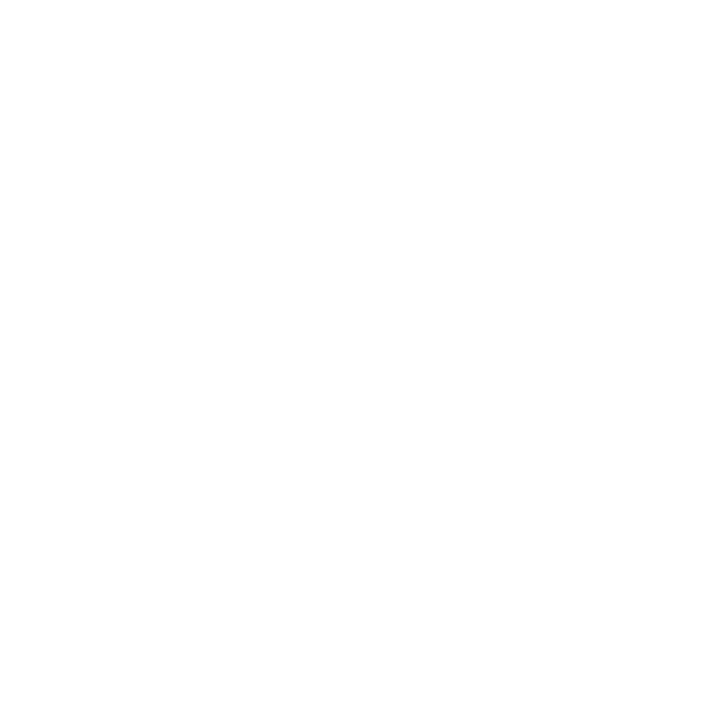

<IPython.core.display.Javascript object>


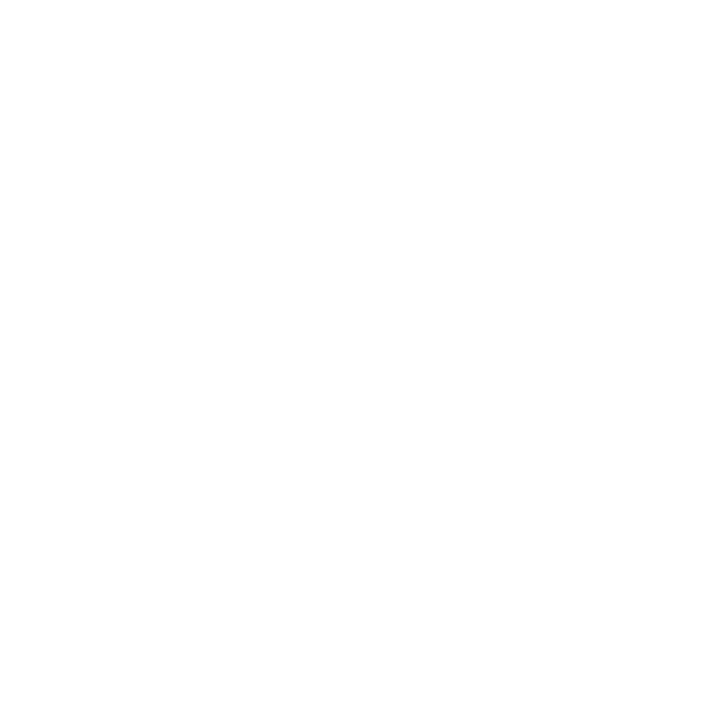

<IPython.core.display.Javascript object>


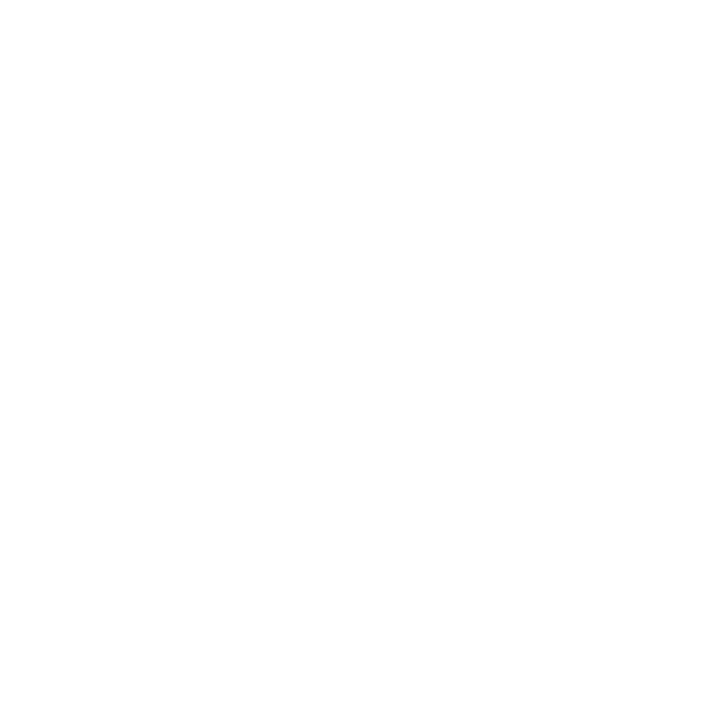

<IPython.core.display.Javascript object>


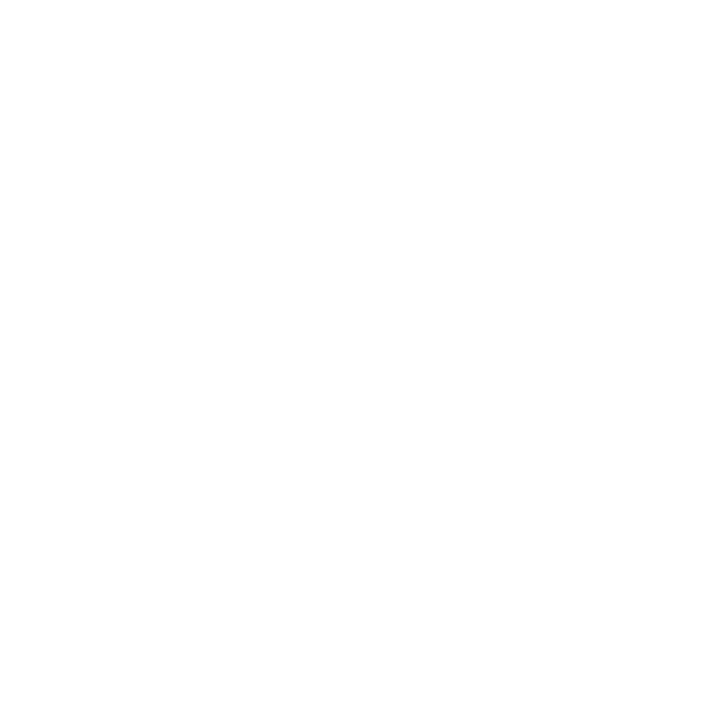

<IPython.core.display.Javascript object>


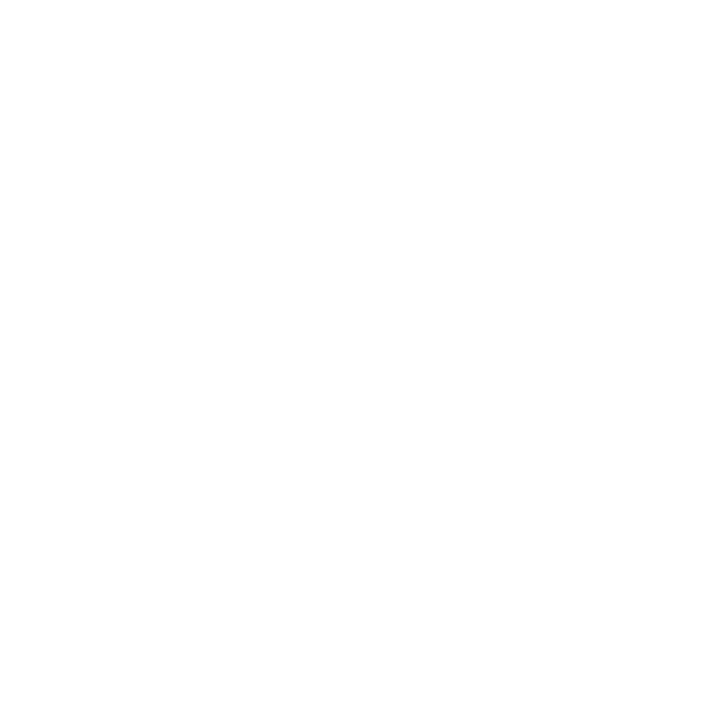

Optimization terminated successfully.
         Current function value: 10.986695
         Iterations: 958
         Function evaluations: 1452


<IPython.core.display.Javascript object>


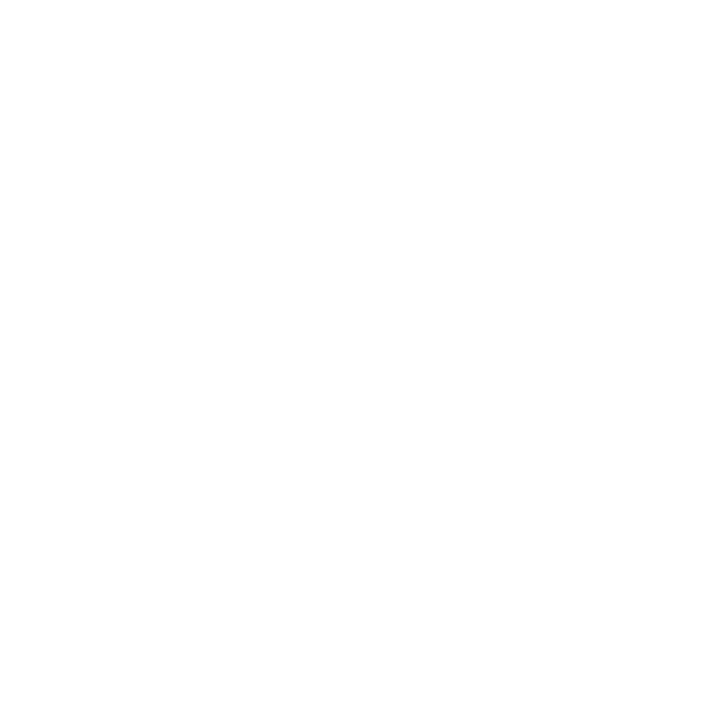

<IPython.core.display.Javascript object>


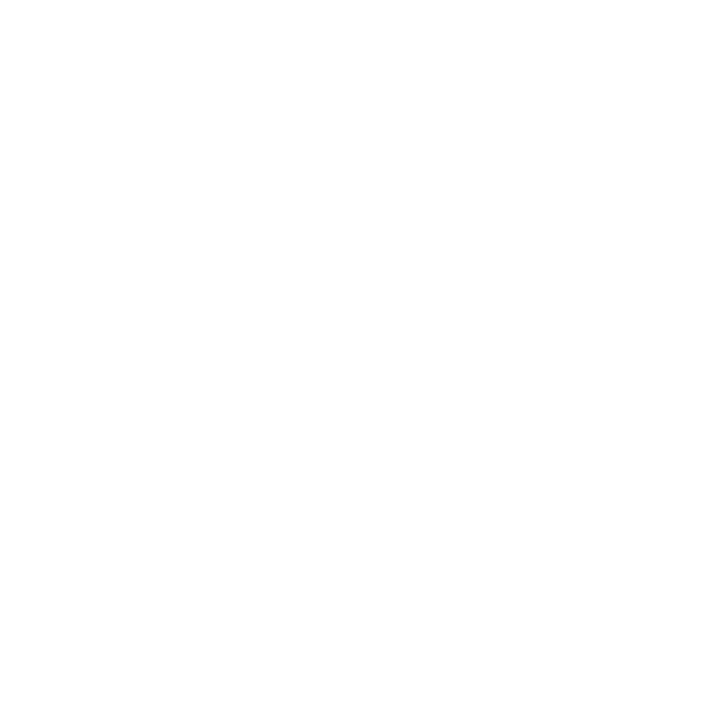

Optimization terminated successfully.
         Current function value: 19.903044
         Iterations: 614
         Function evaluations: 946


<IPython.core.display.Javascript object>


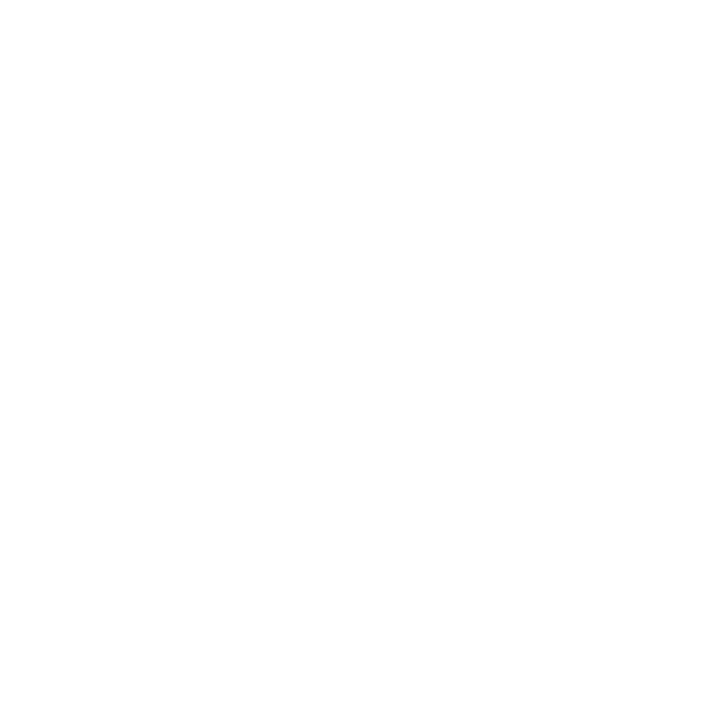

Optimization terminated successfully.
         Current function value: 18.255463
         Iterations: 527
         Function evaluations: 819


<IPython.core.display.Javascript object>


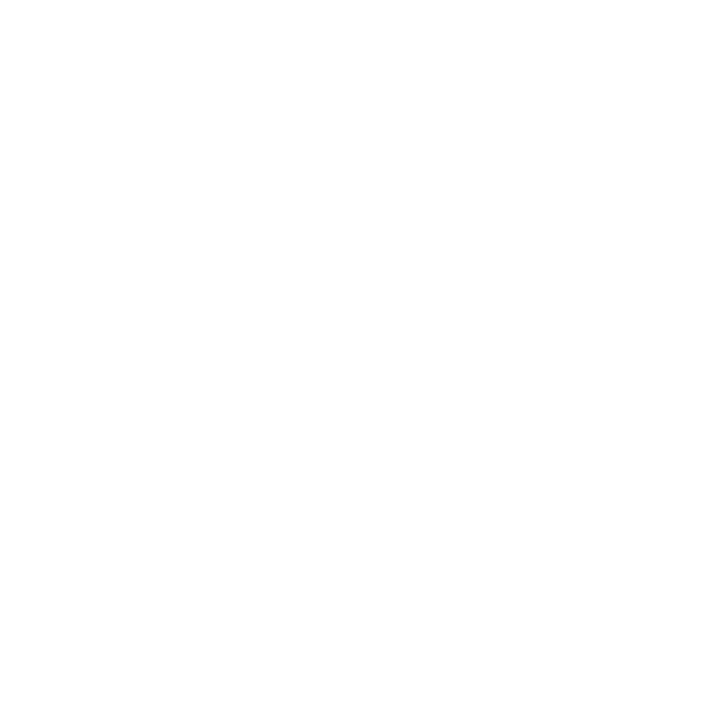

Optimization terminated successfully.
         Current function value: 26.566355
         Iterations: 716
         Function evaluations: 1089


<IPython.core.display.Javascript object>


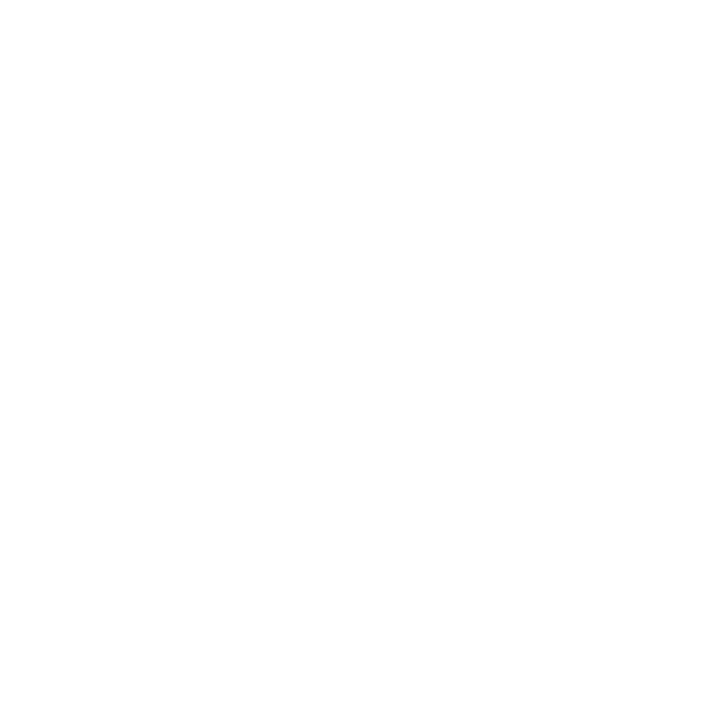

Optimization terminated successfully.
         Current function value: 20.870481
         Iterations: 1658
         Function evaluations: 2284


<IPython.core.display.Javascript object>


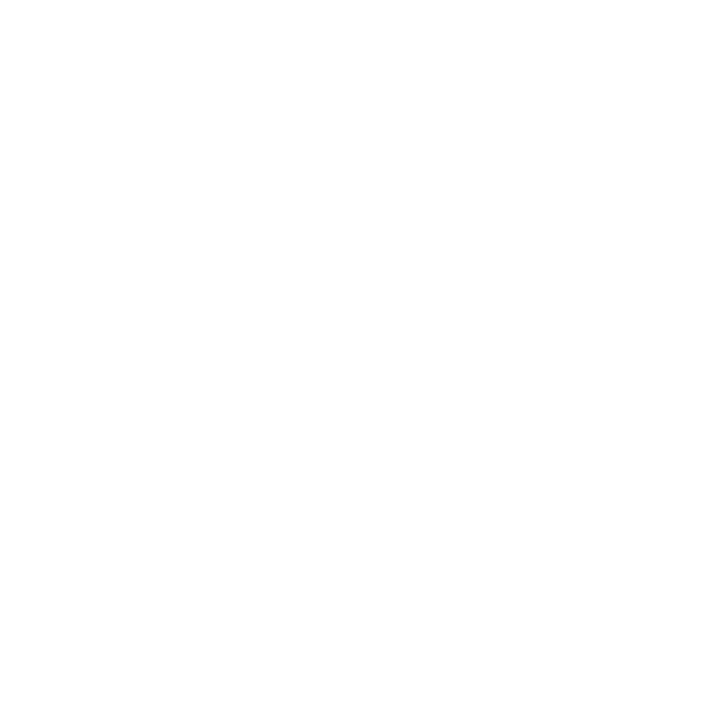

Optimization terminated successfully.
         Current function value: 26.876509
         Iterations: 1383
         Function evaluations: 1945


<IPython.core.display.Javascript object>


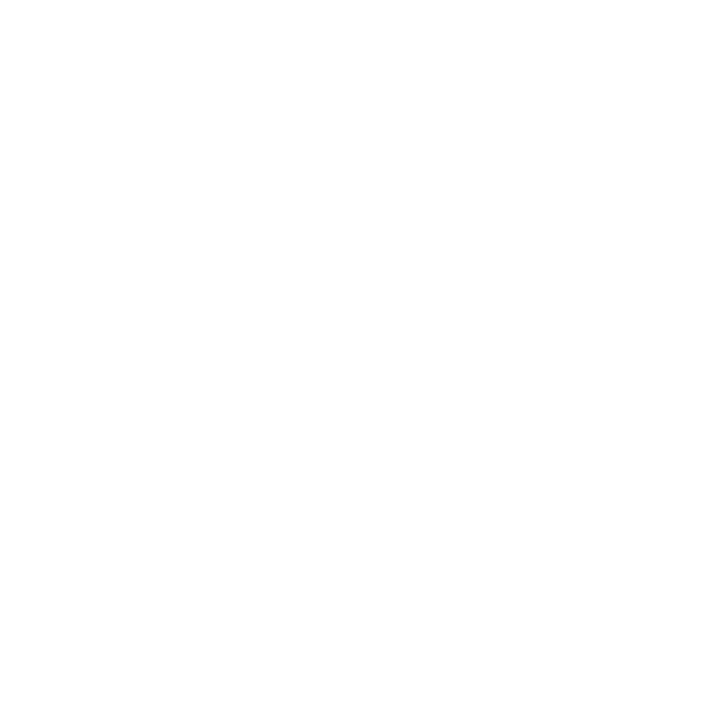

Optimization terminated successfully.
         Current function value: 19.763638
         Iterations: 1710
         Function evaluations: 2359


<IPython.core.display.Javascript object>


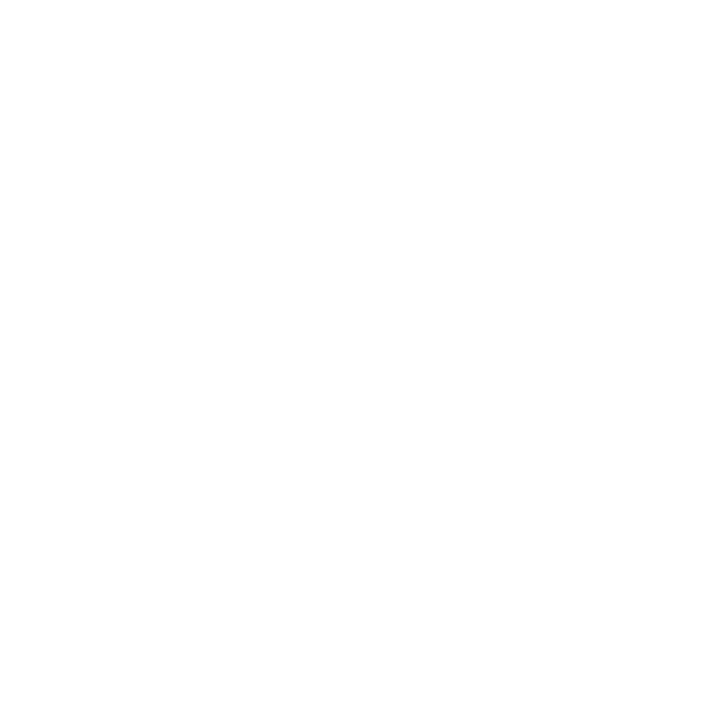

<IPython.core.display.Javascript object>


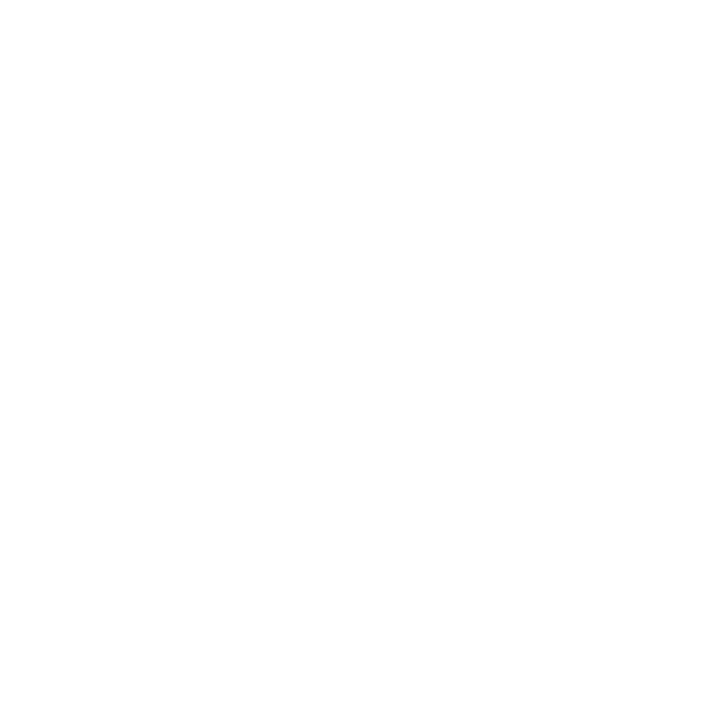

In [9]:
##Conditions on the fit
shiftFreq=35 #number of frequency away from the onset of conduction
cutOff=0.15  #cutoff over which the difference between two subsequent fits are considered too large

##Initialised the different functions. 
#the different functions are set seprately to be able to separate them and make them more readable

###Havrilak-Negami 1
f01=237e3
deltaEps1=80.-26.
a1=0.85
b1=1.0
HNarray1= np.array([f01, deltaEps1, a1, b1])

###Havrilak-Negami 2
f02=3.4e3
deltaEps2=110.
a2=0.85
b2=1.05
HNarray2= np.array([f02, deltaEps2, a2, b2])

###Conduction
sigma=np.exp(-18)
n=0.5
condArray= np.array([sigma, n])

arrayHN2cond=np.array([f01, deltaEps1, a1, b1, f02, deltaEps2, a2, b2,sigma, n, 26., 0.])

newMin=90
resListRef=[]
tempListResRef=[]
    
for ii in range(-2,-16, -1):
    tempListResRef.append(tempListFreq[ii])
    
    #Calculate the limit above which the spectra can be fitted.
    ##First we search for the minimum of the epsIm lose to where we expect it
    ##The limit is a given "distance" number of frequencies away (this may not be the best way as the frequencies are logscale)
    startIndex=specListFreq[ii]['freq'].index[0] #Index at the start of this dataFrame
    minIndex=specListFreq[ii][specListFreq[ii]['epsIm']==min(specListFreq[ii]['epsIm'][newMin-5:])].index[0] #Index of the minimum of the imaginary part of eps for frequencies smaller than lim
    newMin=minIndex-startIndex
    lim=min(newMin+shiftFreq, 211)
    
    #Fit the data for frequencies lower than min
    func=HN2Cond
    epsCompl= np.array(specListFreq[ii]['epsRe'])[:lim]+1j*np.array(specListFreq[ii]['epsIm'])[:lim]
    res=fmin(residuals, arrayHN2cond, args=(np.array(specListFreq[ii]['freq'])[:lim], epsCompl))
    
    if ii!=-2:
        diff=0.
        for jj in range(0, len(res)-2):
            if jj==0 or jj==4 or jj==8:
                diffRes=abs((np.log(res[jj])-np.log(resListRef[-1][jj]))/np.log(resListRef[-1][jj]))
            else:
                diffRes=abs((res[jj]-resListRef[-1][jj])/resListRef[-1][jj])
            if diffRes > diff:
                diff=diffRes
        if diff >0.15:
            param1=resListRef[-1][2:4]
            param2=resListRef[-1][6:8]
            func=HN2CondfixAB
            arrayHN2condfixAB=[resListRef[-1][0], resListRef[-1][1], resListRef[-1][4], resListRef[-1][5], resListRef[-1][8],  resListRef[-1][9], resListRef[-1][10], resListRef[-1][11]]
            resAB=fmin(residuals, arrayHN2condfixAB, args=(np.array(specListFreq[-2]['freq'])[:lim], epsCompl)) 
            
            func=HN2Cond
            arrayHN2cond=np.array([resAB[0], resAB[1], param1[0], param1[1], resAB[2], resAB[3], param2[0], param2[1], resAB[4], resAB[5], resAB[6], resAB[7]])
            res=fmin(residuals, arrayHN2cond, args=(np.array(specListFreq[ii]['freq'])[:lim], epsCompl))
            
    resListRef.append(res)
    arrayHN2cond=res

    
    #plot data
    fig, axes=plt.subplots(2,2, figsize=(6,6))

    for jj in range(2):
        axes[jj,0].plot(np.array(specListFreq[ii]['freq']), np.array(specListFreq[ii]['epsRe']))
        axes[jj,1].plot(np.array(specListFreq[ii]['freq']), np.array(specListFreq[ii]['epsIm']))


        testHN1=HN(specListFreq[0]['freq'], res[0:4])
        axes[jj, 0].plot(specListFreq[0]['freq'], testHN1.real)
        axes[jj, 1].plot(specListFreq[0]['freq'], -testHN1.imag)

        testHN2=HN(specListFreq[0]['freq'], res[4:8])
        axes[jj, 0].plot(specListFreq[0]['freq'], testHN2.real)
        axes[jj, 1].plot(specListFreq[0]['freq'], -testHN2.imag)

        testArray=np.array(HN2Cond(specListFreq[0]['freq'], res))
        axes[jj, 0].plot(np.array(specListFreq[0]['freq']), testArray.real)
        axes[jj, 1].plot(np.array(specListFreq[0]['freq']), -testArray.imag)
        
        axes[jj,0].plot(np.array(specListFreq[ii]['freq'])[lim], np.array(specListFreq[ii]['epsRe'])[lim], 'o')
        axes[jj,1].plot(np.array(specListFreq[ii]['freq'])[lim], np.array(specListFreq[ii]['epsIm'])[lim], 'o')


    axes[0, 0].set_ylim([0,300])
    axes[0, 1].set_ylim([0,100])

    axes[1, 0].set_ylim([0,1200])
    axes[1, 1].set_ylim([0,1200])
    for kk in range(2):
        axes[kk, 0].set_ylabel('epsRe')
        axes[kk, 1].set_ylabel('epsIm')
        for jj in range(2):
            axes[kk,jj].set_xscale('log')
            axes[kk, jj].set_xlabel('Frequency (Hz)')

    axes[0,0].set_title(str(tempListFreq[ii]))
    plt.savefig(folderFit+r"fit_"+str(tempListFreq[ii])+"C.png")
    plt.close()

In [7]:
col=['freq1', 'deltaEps1', 'a1', 'b1','freq2', 'deltaEps2', 'a2', 'b2', 'sigma', 'n', 'epsReInf', 'epsImInf']
FitRestrainAB=pd.DataFrame(resListRef, columns=col)
FitRestrainAB['temp']=tempListResRef

FitRestrainAB.to_excel(folderExcel+r"fit.xlsx", index=False)

<h1> Results of the fit </h1>

In [12]:
relaxFile1=r"C:\Users\3052617\Documents\Boracite\dielectric\190722_CuCl_B\200513_fit_all-free.xlsx"
relaxData1=pd.read_excel(relaxFile1)
relaxData1['log(freq1)']=np.log(relaxData1['freq1'])
relaxData1['log(freq2)']=np.log(relaxData1['freq2'])
relaxData1['temp(K)']=relaxData1['temp']+273

In [13]:
relaxFile2=r"C:\Users\3052617\Documents\Boracite\dielectric\190722_CuCl_B\200513_fit_restrained_a-b.xlsx"
relaxData2=pd.read_excel(relaxFile2)
relaxData2['log(freq1)']=np.log(relaxData2['freq1'])
relaxData2['log(freq2)']=np.log(relaxData2['freq2'])
relaxData2['temp(K)']=relaxData2['temp']+273

<IPython.core.display.Javascript object>


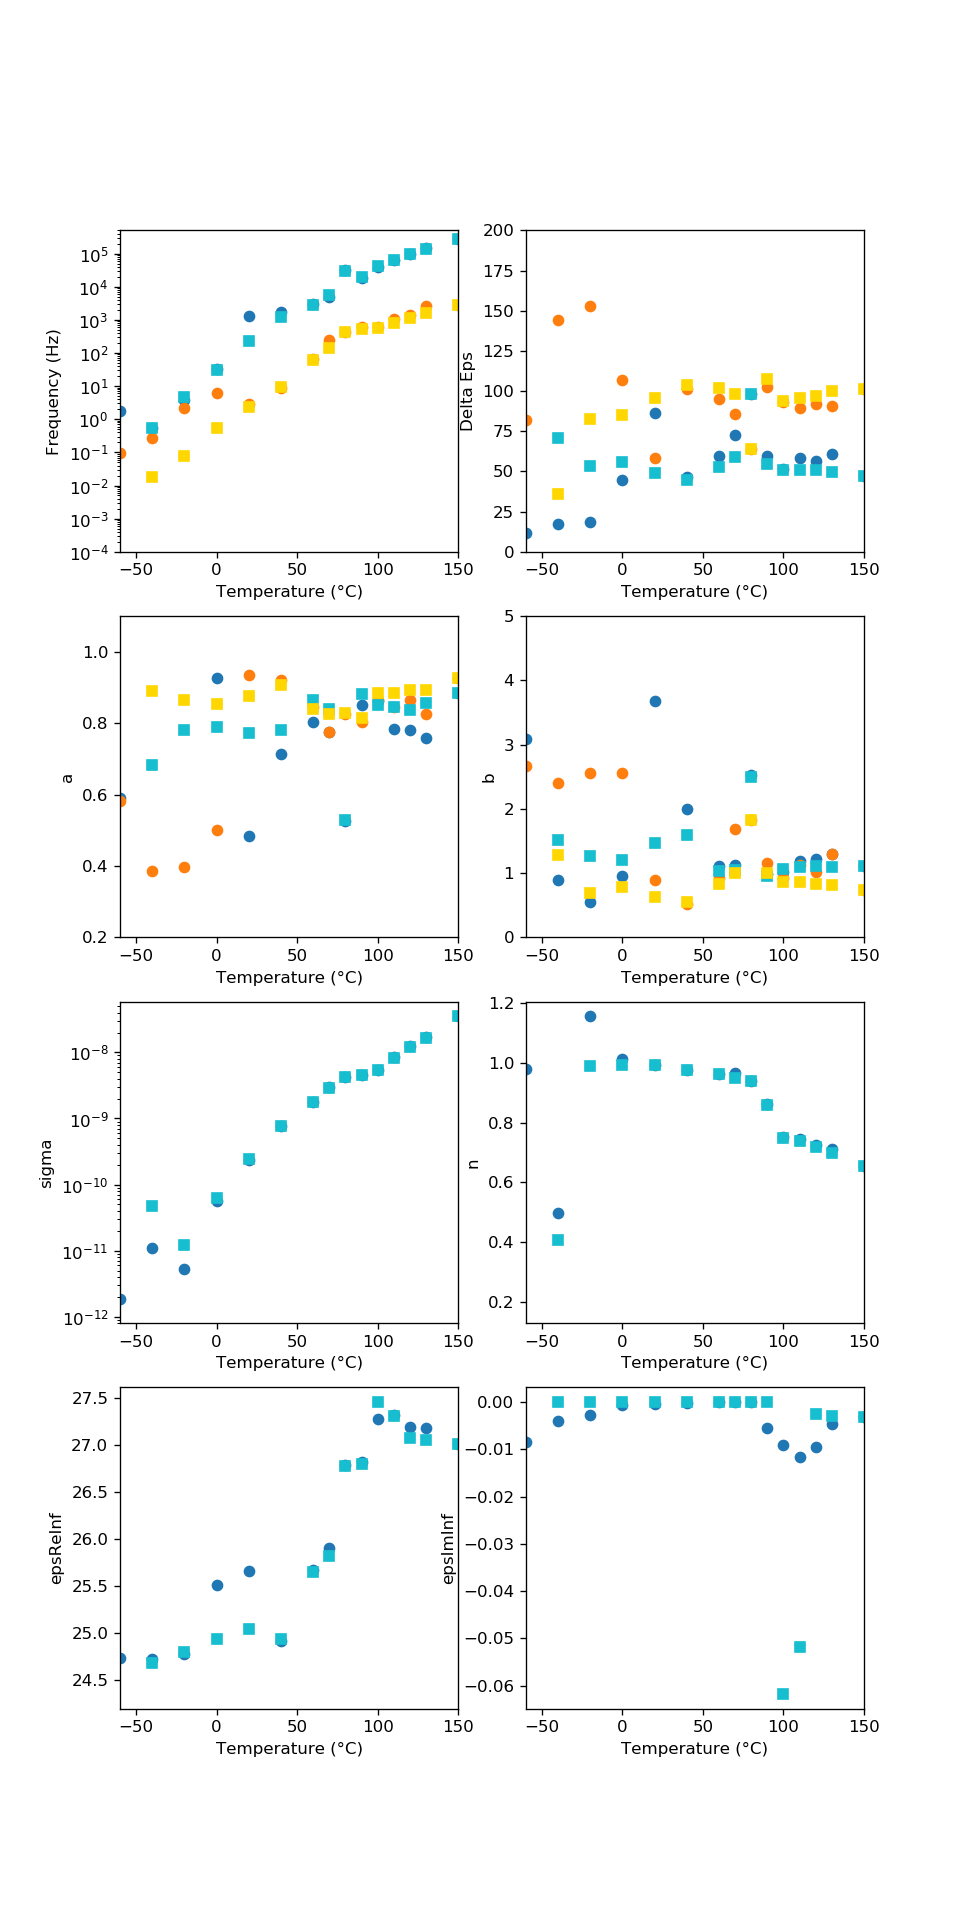

(0, 5)

In [14]:
fig, axes=plt.subplots(4,2, figsize=(8,16))
axes[0,0].plot(relaxData1['temp'], relaxData1['freq1'], 'o', c='tab:blue')
axes[0,0].plot(relaxData1['temp'], relaxData1['freq2'], 'o', c='tab:orange')
axes[0,0].plot(relaxData2['temp'], relaxData2['freq1'], 's', c='tab:cyan')
axes[0,0].plot(relaxData2['temp'], relaxData2['freq2'], 's', c='gold')

axes[0, 1].plot(relaxData1['temp'], relaxData1['deltaEps1'], 'o', c='tab:blue')
axes[0, 1].plot(relaxData1['temp'], relaxData1['deltaEps2'], 'o', c='tab:orange')
axes[0, 1].plot(relaxData2['temp'], relaxData2['deltaEps1'], 's', c='tab:cyan')
axes[0, 1].plot(relaxData2['temp'], relaxData2['deltaEps2'], 's', c='gold')

axes[1,0].plot(relaxData1['temp'], relaxData1['a1'], 'o', c='tab:blue')
axes[1,0].plot(relaxData1['temp'], relaxData1['a2'], 'o', c='tab:orange')
axes[1,0].plot(relaxData2['temp'], relaxData2['a1'], 's', c='tab:cyan')
axes[1,0].plot(relaxData2['temp'], relaxData2['a2'], 's', c='gold')

axes[1, 1].plot(relaxData1['temp'], relaxData1['b1'], 'o', c='tab:blue')
axes[1, 1].plot(relaxData1['temp'], relaxData1['b2'], 'o', c='tab:orange')
axes[1, 1].plot(relaxData2['temp'], relaxData2['b1'], 's', c='tab:cyan')
axes[1, 1].plot(relaxData2['temp'], relaxData2['b2'], 's', c='gold')

axes[2,0].plot(relaxData1['temp'], relaxData1['sigma'], 'o', c='tab:blue')
axes[2,0].plot(relaxData2['temp'], relaxData2['sigma'], 's', c='tab:cyan')

axes[2, 1].plot(relaxData1['temp'], relaxData1['n'], 'o', c='tab:blue')
axes[2, 1].plot(relaxData2['temp'], relaxData2['n'], 's', c='tab:cyan')

axes[3,0].plot(relaxData1['temp'], relaxData1['epsReInf'], 'o',c='tab:blue')
axes[3,0].plot(relaxData2['temp'], relaxData2['epsReInf'], 's',c='tab:cyan')

axes[3,1].plot(relaxData1['temp'], relaxData1['epsImInf'], 'o',c='tab:blue')
axes[3,1].plot(relaxData2['temp'], relaxData2['epsImInf'], 's',c='tab:cyan')


axes[0,0].set_yscale('log')
axes[2,0].set_yscale('log')
axes[0, 0].set_ylabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Delta Eps')
axes[1, 0].set_ylabel('a')
axes[1, 1].set_ylabel('b')
axes[2,0].set_ylabel('sigma')
axes[2,1].set_ylabel('n')
axes[3,0].set_ylabel('epsReInf')
axes[3,1].set_ylabel('epsImInf')
for ii in range(4):
    for jj in range(2):
        axes[ii,jj].set_xlim(-60,150)
        axes[ii,jj].set_xlabel('Temperature (°C)')
axes[0,0].set_ylim(1e-4, 5e5)
axes[0,1].set_ylim(0,200)
axes[1,0].set_ylim(0.2, 1.1)
axes[1,1].set_ylim(0,5)

The circles correspond to the fitting where all the parameters are let free, whereas the squares represent the two step process (fit with a and b fixed, then all parameters free).<br>
As could be expected the main differences are in the values of the a and b exponents which are less temperature sensitive when they are only fitted in a second step. As a knock-on consequence, the amplitude of the relaxation processes are a lot smoother. The main features however remain the same.